In [138]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

## Purpose

Want to simulate a scenario where neurons change their connectivity and firing rate in response to a ripple event.

This is to understand how the data might look and think through the different scenarios.

Monosynaptic connections on the order of 15 ms. Connections are probably polysynaptic (30 ms).

#### Conditions

+ Pre1: Two neurons, different firing rate, no dependence
+ Post1: Two neurons, increasing firing rate, dependence
+ Post2: Two neurons, increasing firing rate, no dependence


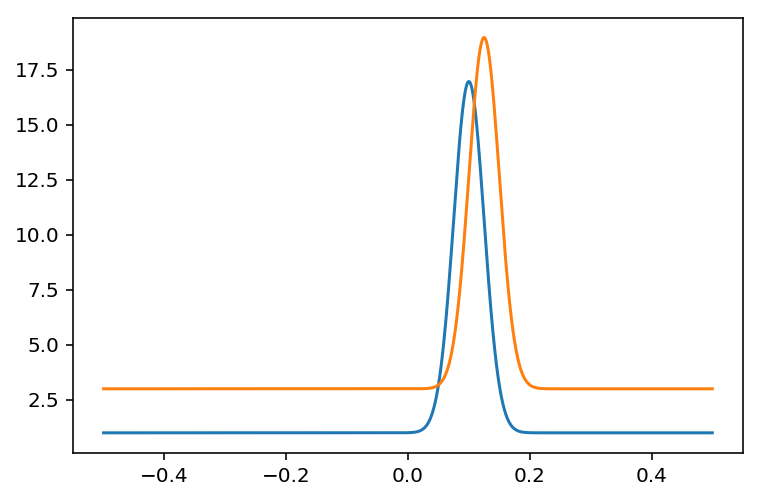

In [20]:
from scipy.stats import norm

sampling_frequency = 1500
n_samples = sampling_frequency * 1

time = np.arange(n_samples) / sampling_frequency
time -= time.max() / 2

rate1 = norm(loc=0.100, scale=0.025).pdf(time) + 1
rate2 = norm(loc=0.125, scale=0.025).pdf(time) + 3

plt.plot(time, rate1)
plt.plot(time, rate2)

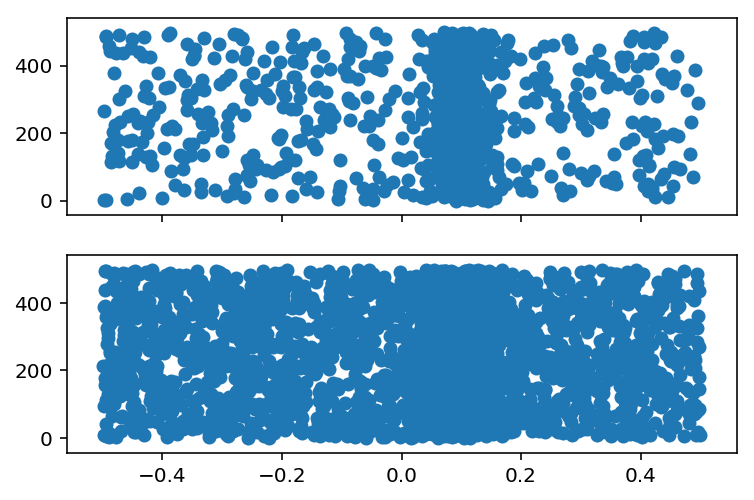

In [114]:
from src.spike_train import simulate_poisson_process

n_trials = 500
n_delay_samples = int(0.030 * sampling_frequency)

spikes1 = simulate_poisson_process(rate1[:, np.newaxis] * np.ones((1, n_trials)), sampling_frequency)
spike_times_ind, trial_ind = np.nonzero(spikes1)
delay_ind = spike_times_ind - n_delay_samples
good_delay  = delay_ind >= 0
delay_ind = delay_ind[good_delay]
trial_ind = trial_ind[good_delay]

spikes2 = simulate_poisson_process(rate2[:, np.newaxis] * np.ones((1, n_trials)), sampling_frequency)
spikes2[delay_ind, trial_ind] = 1

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)

spikes_times1, trial_id = np.nonzero(spikes1)
axes[0].scatter(time[spikes_times1], trial_id)

spikes_times2, trial_id = np.nonzero(spikes2)
axes[1].scatter(time[spikes_times2], trial_id);

In [116]:
from regularized_glm import penalized_IRLS
from statsmodels.api import families
from src.spike_models import lag


design_matrix = np.ones_like(spikes1.ravel(order='F'))

results = penalized_IRLS(design_matrix, spikes1.ravel(order='F'), family=families.Poisson())
np.exp(results.coefficients) * sampling_frequency


array([[1.986]])

In [117]:
results = penalized_IRLS(design_matrix, spikes2.ravel(order='F'), family=families.Poisson())
np.exp(results.coefficients) * sampling_frequency

array([[5.96]])

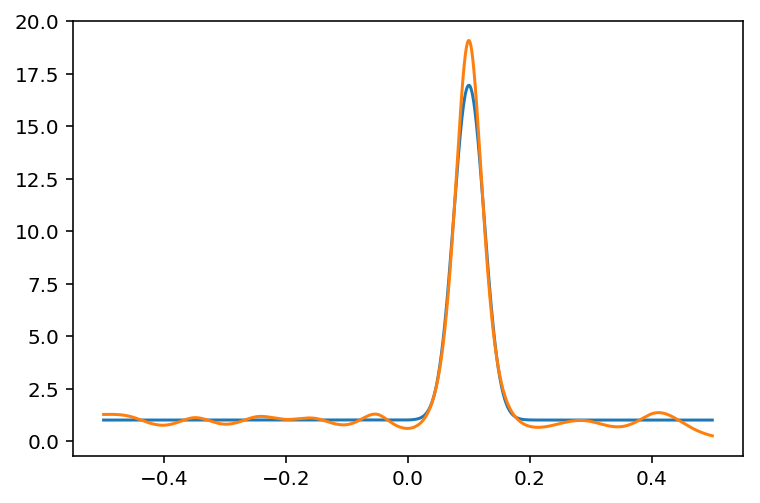

In [133]:
from patsy import dmatrices, build_design_matrices

data = {
    'is_spike': spikes1.ravel(order='F'),
    'time': (time[:, np.newaxis] * np.ones((1, n_trials))).ravel(order='F')
}

knot_spacing = 0.050
n_steps = (time.max() - time.min()) // knot_spacing
time_knots = time.min() + np.arange(1, n_steps) * knot_spacing
formula = '1 + cr(time, knots=time_knots, constraints="center")'

formula = ('is_spike ~ 1 + cr(time, knots=time_knots,'
           ' constraints="center")')
is_spike, design_matrix = dmatrices(formula, data)
results = penalized_IRLS(design_matrix, is_spike, family=families.Poisson())
predict_design_matrix = build_design_matrices(
    [design_matrix.design_info], dict(time=time))[0]

plt.plot(time, rate1)
plt.plot(time, np.exp(predict_design_matrix @ results.coefficients) * sampling_frequency);


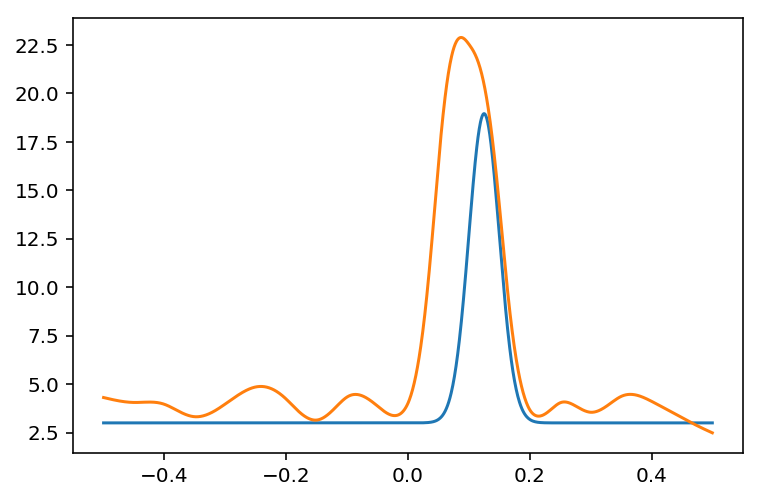

In [134]:
from patsy import dmatrices, build_design_matrices

data = {
    'is_spike': spikes2.ravel(order='F'),
    'time': (time[:, np.newaxis] * np.ones((1, n_trials))).ravel(order='F')
}

knot_spacing = 0.050
n_steps = (time.max() - time.min()) // knot_spacing
time_knots = time.min() + np.arange(1, n_steps) * knot_spacing
formula = '1 + cr(time, knots=time_knots, constraints="center")'

formula = ('is_spike ~ 1 + cr(time, knots=time_knots,'
           ' constraints="center")')
is_spike, design_matrix = dmatrices(formula, data)
results = penalized_IRLS(design_matrix, is_spike, family=families.Poisson())
predict_design_matrix = build_design_matrices(
    [design_matrix.design_info], dict(time=time))[0]

plt.plot(time, rate2)
plt.plot(time, np.exp(predict_design_matrix @ results.coefficients) * sampling_frequency);


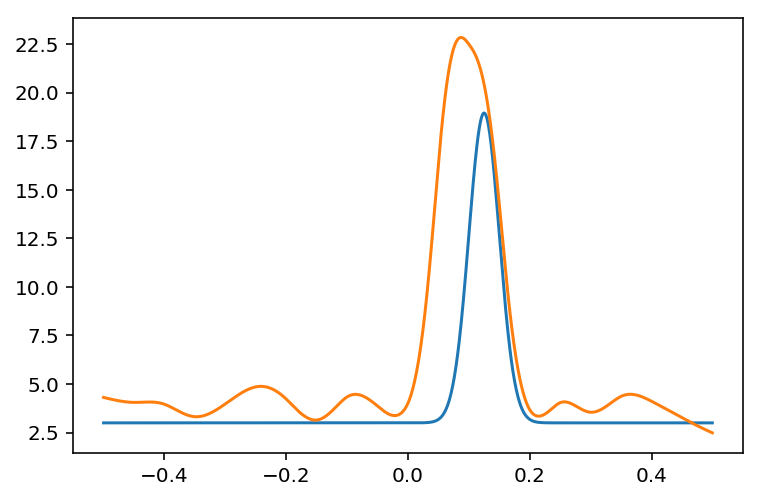

In [150]:
from patsy import dmatrices, build_design_matrices
from src.spike_models import lag

data = {
    'is_spike1': spikes1.ravel(order='F'),
    'is_spike2': spikes2.ravel(order='F'),
    'time': (time[:, np.newaxis] * np.ones((1, n_trials))).ravel(order='F')
}

knot_spacing = 0.050
n_steps = (time.max() - time.min()) // knot_spacing
time_knots = time.min() + np.arange(1, n_steps) * knot_spacing

formula = ('is_spike2 ~ 1 + cr(time, knots=time_knots,'
           ' constraints="center") + lag(is_spike1, n_lags=50).values')
is_spike, design_matrix = dmatrices(formula, data)
results = penalized_IRLS(design_matrix, is_spike, family=families.Poisson())
predict_data = {
    'time': time,
    'is_spike1': np.zeros_like(time)
}
predict_design_matrix = build_design_matrices(
    [design_matrix.design_info], predict_data)[0]

plt.plot(time, rate2)
plt.plot(time, np.exp(predict_design_matrix @ results.coefficients) * sampling_frequency);


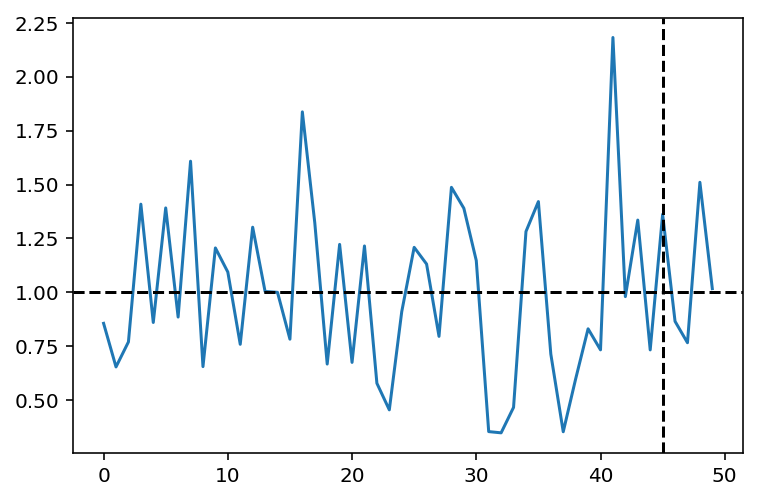

In [163]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.exp(results.coefficients[20:70]))
ax.axvline(n_delay_samples, color='black', linestyle='--')
ax.axhline(1, color='black', linestyle='--');

In [170]:
rate = np.ones((5000)) * 5
spikes = simulate_poisson_process(rate, sampling_frequency)
spikes2 = np.concatenate((np.zeros(45,), spikes[:-45]))

data = {
    'is_spike1': spikes,
    'is_spike2': spikes2,
}

formula = 'is_spike1 ~ lag(is_spike2, n_lags=50).values'